In [150]:
import requests
import pandas as pd
import io
import time
import API_info#file to keep your API key
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [151]:
headers = {'authorization': 'Bearer '+API_info.API_key}
base_url = "https://public.enigma.com/api/"

# Define a function to get data from the Enigma API

In [152]:
def getEnigmaData(dataid):
    #Get the dataset current snapshot
    url = base_url + 'datasets/{}'.format(dataid)
    response = requests.get(url, headers=headers)
    json = response.json()
    snapshot_id = json['current_snapshot']['id']#get most recent snapshot of dataset

    #Get the dataset
    url = base_url + 'export/{}'.format(snapshot_id)
    print('Reading data from Enigma API to pandas...')
    startread=time.time()
    response = requests.get(url, headers=headers).content
    print('Read took '+str(time.time()-startread)+' seconds.')
    return pd.read_csv(io.StringIO(response.decode('utf-8')))

# I'm going to focus on the relationship between drug type, disease type, medicare spending and how much we're spending for drugs on drugs with known adverse effects

## To do this, I'm going to use the FDA adverse events dataset and the medicare drug spending dataset

In [153]:
##########Access Enigma Public Through Pandas#############
#dataset_id = 'fa7ab996-fb43-4e86-80e7-f8e82ccba15f'
#dataset_id = 'a4fecc00-1442-4b3c-b6d5-5866feb95f8b'#Medicare drug spending 2010-2015
#dataset_id = '7f824984-adcb-4fb9-a481-00ecd3d9f0cb'#Health Interview Survey 2012

dataset_id_advevents = 'd6bad17f-ee0b-4f3d-9fa0-bb85cd7e68c0'#Curated FDA adverse events 2016
dfAdvEvents = getEnigmaData(dataset_id_advevents)

dataset_id_medspend = 'a4fecc00-1442-4b3c-b6d5-5866feb95f8b'#Medicare drug spending 2010-2015
dfMedSpend = getEnigmaData(dataset_id_medspend)

Reading data from Enigma API to pandas...
Read took 80.17930197715759 seconds.


/home/ben/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Reading data from Enigma API to pandas...
Read took 5.565113544464111 seconds.


In [ ]:
dfAdvEvents.keys()
#dfAdvEvents.groupby(['outc_cod_definition']).describe()

In [ ]:
dfMedSpend.keys()

### Let's take a look at the common terms in each of these datasets...

In [99]:
#check which bran name drugs are also included in the adverse drug data
print(list(set(list(dfAdvEvents.drugname)) & set(list(dfMedSpend.brand_name))))
#check which generic drugs are also included in the adverse drug data
print(sorted(list(set(list(dfAdvEvents.drugname)) & set(list(dfMedSpend.generic_name)))))

['Propranolol HCl', 'Clomipramine Hcl', 'Duloxetine HCl']
['Adalimumab', 'Aflibercept', 'Alteplase', 'Ambrisentan', 'Bendamustine HCl', 'Bevacizumab', 'Bortezomib', 'Bosentan', 'Bupropion HCl', 'Carfilzomib', 'Cetuximab', 'Denosumab', 'Duloxetine HCl', 'Enzalutamide', 'Etanercept', 'Everolimus', 'Fluticasone/Salmeterol', 'Fulvestrant', 'Ibrutinib', 'Infliximab', 'Ipilimumab', 'Ledipasvir/Sofosbuvir', 'Lenalidomide', 'Metformin HCl', 'Omalizumab', 'Pegfilgrastim', 'Propranolol HCl', 'Ranibizumab', 'Rituximab', 'Rivaroxaban', 'Sofosbuvir', 'Teriparatide', 'Trastuzumab']


# Let's take a shallow glance at correlations in adverse events and spending

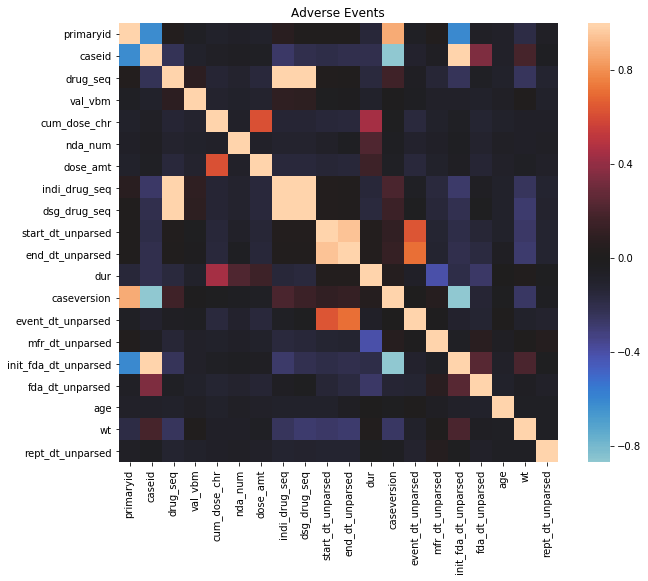

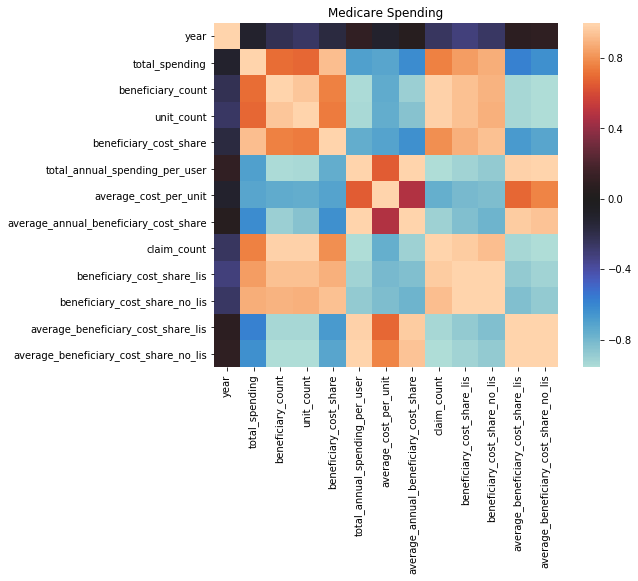

In [118]:

def plot_corr(df,size=18,plottitle=''):

    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr,
                square=True, ax=ax,center=0.0)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(plottitle)
    
plot_corr(dfAdvEvents.corr(),plottitle='Adverse Events')
plot_corr(dfMedSpend.corr(),plottitle='Medicare Spending')

In [ ]:
mergedEventsSpend = pd.merge(dfAdvEvents,dfMedSpend, left_on='drugname',right_on=['generic_name'])
mergedEventsSpend.keys()

# Let's see how type of disease influences spending first

In [ ]:
#indi_pt=indicated preferred term
mergedEventsSpend.groupby(['total_spending','indi_pt']).mean()['total_annual_spending_per_user']

#plt.plot(sorted(mergedEventsSpend.groupby(['total_spending','indi_pt']).mean()['total_annual_spending_per_user']))